In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
df = pd.read_csv('Amazon_Beauty_Recommendation.csv')
df.head()

,UserId,ProductId,ProductType,Rating,Timestamp,URL
0,A3NHUQ33CFH3VM,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
1,A1TIRNQ7O4REOH,B00LLPT4HI,Eyeliner & Kajal,4,1405987200,https://www.amazon.in/Maybelline-Colossal-Kaja...
2,A2Y36BR4YSY9F7,B00LLPT4HI,Eyeliner & Kajal,5,1405728000,https://www.amazon.in/Maybelline-Colossal-Kaja...
3,A23H6FAOLEMAKC,B00LLPT4HI,Eyeliner & Kajal,5,1405814400,https://www.amazon.in/Maybelline-Colossal-Kaja...
4,A3CHYZGF3OO6WD,B00LLPT4HI,Eyeliner & Kajal,5,1405641600,https://www.amazon.in/Maybelline-Colossal-Kaja...


In [3]:
print(df[['UserId', 'ProductId', 'Timestamp']].head())

           UserId   ProductId   Timestamp
0  A3NHUQ33CFH3VM  B00LLPT4HI  1405814400
1  A1TIRNQ7O4REOH  B00LLPT4HI  1405987200
2  A2Y36BR4YSY9F7  B00LLPT4HI  1405728000
3  A23H6FAOLEMAKC  B00LLPT4HI  1405814400
4  A3CHYZGF3OO6WD  B00LLPT4HI  1405641600


In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
print(df[['UserId', 'ProductId', 'Timestamp']].head())
print(df.shape)

           UserId   ProductId  Timestamp
0  A3NHUQ33CFH3VM  B00LLPT4HI 2014-07-20
1  A1TIRNQ7O4REOH  B00LLPT4HI 2014-07-22
2  A2Y36BR4YSY9F7  B00LLPT4HI 2014-07-19
3  A23H6FAOLEMAKC  B00LLPT4HI 2014-07-20
4  A3CHYZGF3OO6WD  B00LLPT4HI 2014-07-18
(1348246, 6)


In [5]:
user_counts = df['UserId'].value_counts()
filtered_users = user_counts[user_counts >= 5].index
df = df[df['UserId'].isin(filtered_users)]
print(f"Data after filtering: {df.shape}")

Data after filtering: (243601, 6)


In [6]:
item_counts = df['ProductId'].value_counts()
filtered_items = item_counts[item_counts >= 5].index
df = df[df['ProductId'].isin(filtered_items)]

print(f"Data after filtering: {df.shape}")

Data after filtering: (219119, 6)


In [7]:
user_encoder = LabelEncoder()
df['UserId'] = user_encoder.fit_transform(df['UserId'])+1
df['UserId'].max()

28035

In [8]:
item_encoder = LabelEncoder()
df['ProductId'] = item_encoder.fit_transform(df['ProductId']) + 1
df['ProductId'].max()

12704

In [9]:
num_items = df['ProductId'].max() + 1
print(f"Total number of items including padding index: {num_items}")

Total number of items including padding index: 12705


In [10]:
df = df.sort_values(['UserId', 'Timestamp']).reset_index(drop=True)
df.head()

,UserId,ProductId,ProductType,Rating,Timestamp,URL
0,1,12520,Shaving Foam & Gels,5,2014-07-14,https://www.amazon.in/gp/slredirect/picassoRed...
1,1,12421,Trimmers & Clippers,5,2014-07-14,https://www.amazon.in/Philips-BT3215-Cordless-...
2,1,11836,Kits & Accessories,3,2014-07-14,https://www.amazon.in/SUGAR-POP-Exclusive-Esse...
3,1,10802,Conditioner,1,2014-07-14,https://www.amazon.in/Garnier-Fructis-Strong-S...
4,1,10565,Conditioner,2,2014-07-14,https://www.amazon.in/LOreal-Paris-RESIST-Cond...


In [11]:
user_sequences = df.groupby('UserId')['ProductId'].apply(list).values
print(user_sequences[:5])
print(len(user_sequences))

[list([12520, 12421, 11836, 10802, 10565, 10186])
 list([3694, 9806, 5040, 4580, 11636, 55])
 list([6985, 4850, 4661, 9396, 6227, 492, 10974, 10137])
 list([10861, 9692, 9564, 9397, 10880, 10498, 3890])
 list([9662, 11043, 10892, 9089, 8810, 5610, 10951, 9564])]
28035


In [12]:
if (df['ProductId'] == 0).any():
    print("The encoder assigned 0 as a value for some ProductId entries.")
else:
    print("No ProductId entry has been assigned the value 0.")


No ProductId entry has been assigned the value 0.


In [13]:
def generate_sequences(sequence, window_size=10):
    if len(sequence) < window_size:
        sequence = [0] * (window_size - len(sequence)) + sequence
    return [sequence[i:i + window_size] for i in range(len(sequence) - window_size + 1)]

In [14]:
all_sequences = []
for seq in user_sequences:
    all_sequences.extend(generate_sequences(seq))
print(len(all_sequences))

67761


In [15]:
print(all_sequences[:20])

[[0, 0, 0, 0, 12520, 12421, 11836, 10802, 10565, 10186], [0, 0, 0, 0, 3694, 9806, 5040, 4580, 11636, 55], [0, 0, 6985, 4850, 4661, 9396, 6227, 492, 10974, 10137], [0, 0, 0, 10861, 9692, 9564, 9397, 10880, 10498, 3890], [0, 0, 9662, 11043, 10892, 9089, 8810, 5610, 10951, 9564], [0, 0, 0, 0, 0, 6643, 5649, 4783, 1095, 856], [10610, 4019, 4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122], [4019, 4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122, 9928], [4338, 9407, 8525, 8762, 6598, 3044, 9937, 5122, 9928, 8149], [0, 0, 0, 0, 0, 0, 11348, 11082, 11597, 11803], [0, 0, 0, 0, 11614, 10582, 10498, 10363, 10323, 7219], [0, 0, 0, 5906, 496, 4734, 2710, 4183, 3283, 3438], [0, 0, 0, 0, 652, 1347, 1046, 8589, 8108, 3266], [7817, 8269, 4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336], [8269, 4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958], [4328, 3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958, 9353], [3350, 10986, 10303, 8594, 7245, 4337, 4336, 5958, 9353, 11083], [10986, 10303, 8594, 7245, 4

In [16]:
all_sequences = torch.tensor(all_sequences, dtype=torch.long)
inputs = all_sequences[:, :-1]
targets = all_sequences[:, -1]

In [17]:
print(inputs)


tensor([[    0,     0,     0,  ..., 11836, 10802, 10565],
        [    0,     0,     0,  ...,  5040,  4580, 11636],
        [    0,     0,  6985,  ...,  6227,   492, 10974],
        ...,
        [ 6122,  5562,  5362,  ...,  9933,  8364,  6481],
        [    0,     0,     0,  ..., 11713, 10830,  7269],
        [    0,     0,     0,  ...,  9392,  9265,  7728]])


In [18]:
print(inputs[:20])

tensor([[    0,     0,     0,     0, 12520, 12421, 11836, 10802, 10565],
        [    0,     0,     0,     0,  3694,  9806,  5040,  4580, 11636],
        [    0,     0,  6985,  4850,  4661,  9396,  6227,   492, 10974],
        [    0,     0,     0, 10861,  9692,  9564,  9397, 10880, 10498],
        [    0,     0,  9662, 11043, 10892,  9089,  8810,  5610, 10951],
        [    0,     0,     0,     0,     0,  6643,  5649,  4783,  1095],
        [10610,  4019,  4338,  9407,  8525,  8762,  6598,  3044,  9937],
        [ 4019,  4338,  9407,  8525,  8762,  6598,  3044,  9937,  5122],
        [ 4338,  9407,  8525,  8762,  6598,  3044,  9937,  5122,  9928],
        [    0,     0,     0,     0,     0,     0, 11348, 11082, 11597],
        [    0,     0,     0,     0, 11614, 10582, 10498, 10363, 10323],
        [    0,     0,     0,  5906,   496,  4734,  2710,  4183,  3283],
        [    0,     0,     0,     0,   652,  1347,  1046,  8589,  8108],
        [ 7817,  8269,  4328,  3350, 10986, 10303, 

In [19]:
print(targets)


tensor([10186,    55, 10137,  ...,  2814,  7351,  2347])


In [20]:
print(f'Inputs shape: {inputs.shape}, Targets shape: {targets.shape}')

Inputs shape: torch.Size([67761, 9]), Targets shape: torch.Size([67761])


In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split


dataset = TensorDataset(inputs, targets)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")


Train size: 47432
Validation size: 10164
Test size: 10165


In [22]:
for batch_inputs, batch_targets in train_loader:
    print(f'Batch Inputs: {batch_inputs.shape}, Batch Targets: {batch_targets.shape}')
    break

Batch Inputs: torch.Size([32, 9]), Batch Targets: torch.Size([32])


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads

        assert embedding_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)

        self.out = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, E = x.size()

        Q = self.query(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        output = torch.matmul(attn, V)
        output = output.transpose(1, 2).contiguous().view(B, N, E)

        return self.out(output)

class PointWiseFeedForward(nn.Module):
    def __init__(self, embedding_dim, ff_dim, dropout=0.1):
        super(PointWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(embedding_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, embedding_dim)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        return self.linear2(x)

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.msa = MultiHeadSelfAttention(embedding_dim, num_heads, dropout)
        self.ffn = PointWiseFeedForward(embedding_dim, ff_dim, dropout)

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.msa(self.norm1(x)))

        x = x + self.dropout(self.ffn(self.norm2(x)))

        return x

class UET4Rec(nn.Module):
    def __init__(self, num_items, embedding_dim=64, nhead=4, max_len=50, dropout=0.2, ff_dim=256):
        super(UET4Rec, self).__init__()

        self.item_embedding = nn.Embedding(num_items, embedding_dim, padding_idx=0)

        self.position_embedding = nn.Embedding(max_len, embedding_dim)

        self.encoder1 = nn.Sequential(
            nn.Conv1d(embedding_dim, embedding_dim // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv1d(embedding_dim // 2, embedding_dim // 4, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.encoder3 = nn.Sequential(
            nn.Conv1d(embedding_dim // 4, embedding_dim // 8, kernel_size=5, padding=2)
        )

        self.transformer = nn.ModuleList([
            CustomTransformerEncoderLayer(embedding_dim // 8, nhead, ff_dim, dropout) for _ in range(3)
        ])

        self.decoder1 = nn.Sequential(
            nn.Conv1d(embedding_dim // 8, embedding_dim // 4, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 4),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.decoder2 = nn.Sequential(
            nn.Conv1d(embedding_dim // 4, embedding_dim // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(embedding_dim // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )

        self.decoder3 = nn.Sequential(
            nn.Conv1d(embedding_dim // 2, embedding_dim, kernel_size=5, padding=2)
        )

        self.fc = nn.Linear(embedding_dim, num_items)

    def forward(self, x):
        batch_size, seq_len = x.size()

        positions = torch.arange(0, seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        x = self.item_embedding(x) + self.position_embedding(positions)

        x = x.permute(0, 2, 1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        x = enc3.permute(0, 2, 1)
        for layer in self.transformer:
            x = layer(x)
        x = x.permute(0, 2, 1)

        dec1 = self.decoder1(x + enc3)
        dec2 = self.decoder2(dec1 + enc2)
        dec3 = self.decoder3(dec2 + enc1)
        x = dec3[:, :, -1]
        out = self.fc(x)

        return out


In [26]:
embedding_dim = 64
nhead = 4
ff_dim = 256
dropout = 0.2
max_len = 9

model = UET4Rec(
    num_items=num_items,
    embedding_dim=embedding_dim,
    nhead=nhead,
    max_len=max_len,
    dropout=dropout,
    ff_dim=ff_dim
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

UET4Rec(
  (item_embedding): Embedding(12705, 64, padding_idx=0)
  (position_embedding): Embedding(9, 64)
  (encoder1): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder3): Sequential(
    (0): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (transformer): ModuleList(
    (0-2): 3 x CustomTransformerEncoderLayer(
      (msa): MultiHeadSelfAttention(
        (query): Linear(in_features=8, out_features=8, bias=True)
        (key): Linear(in_features=8, out_features=8, bias=True)
        (value): Linea

In [28]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def clip_gradients(model, clip_value):
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.clamp_(-clip_value, clip_value)

num_epochs = 150
save_interval = 20

def adjust_learning_rate(optimizer, epoch, warmup_epochs=10, warmup_lr=0.005, main_lr=0.001):
    if epoch < warmup_epochs:
        lr = warmup_lr
    else:
        lr = main_lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def calculate_metrics(model, val_loader, ks=[5, 10, 20]):
    model.eval()
    total_hr = {k: 0 for k in ks}
    total_ndcg = {k: 0 for k in ks}
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            outputs = model(batch_inputs)
            _, top_k_indices = torch.topk(outputs, k=max(ks), dim=1)

            for i in range(batch_targets.size(0)):
                target = batch_targets[i].item()
                predictions = top_k_indices[i].cpu().numpy()

                for k in ks:
                    top_k_preds = predictions[:k]

                    if target in top_k_preds:
                        total_hr[k] += 1

                    if target in top_k_preds:
                        rank = np.where(top_k_preds == target)[0][0] + 1
                        total_ndcg[k] += 1 / np.log2(rank + 1)

            total_samples += batch_targets.size(0)

    hr = {k: total_hr[k] / total_samples for k in ks}
    ndcg = {k: total_ndcg[k] / total_samples for k in ks}

    return hr, ndcg

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    adjust_learning_rate(optimizer, epoch, warmup_epochs=10, warmup_lr=0.005, main_lr=0.001)

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as progress_bar:
        for batch_idx, (batch_inputs, batch_targets) in enumerate(progress_bar):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()

            outputs = model(batch_inputs)

            loss = criterion(outputs, batch_targets)

            loss.backward()

            clip_gradients(model, clip_value=1.0)

            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == batch_targets).sum().item()
            total_predictions += batch_targets.size(0)

            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    if (epoch + 1) % save_interval == 0:
        model_save_path = f"uet4rec64_beauty_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved after {epoch+1} epochs at '{model_save_path}'.")

        print("\nCalculating metrics...")
        hr, ndcg = calculate_metrics(model, val_loader, ks=[5, 10, 20])
        for k in [5, 10, 20]:
            print(f"HR@{k}: {hr[k]:.4f}, NDCG@{k}: {ndcg[k]:.4f}")

final_model_path = "uet4rec64_beauty_model_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved as '{final_model_path}'.")

print("Training Completed.")


Using device: cuda
Starting Training...


Epoch [1/150]: 100%|████████████████████████████████████████████| 1483/1483 [00:39<00:00, 37.20batch/s, Batch Loss=7.4]


Epoch [1/150], Training Loss: 8.7285, Accuracy: 0.0029


Epoch [2/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:37<00:00, 39.97batch/s, Batch Loss=8.86]


Epoch [2/150], Training Loss: 8.0458, Accuracy: 0.0100


Epoch [3/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:34<00:00, 42.94batch/s, Batch Loss=6.83]


Epoch [3/150], Training Loss: 7.6675, Accuracy: 0.0207


Epoch [4/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:32<00:00, 45.50batch/s, Batch Loss=7.17]


Epoch [4/150], Training Loss: 6.9889, Accuracy: 0.0335


Epoch [5/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:32<00:00, 45.03batch/s, Batch Loss=6.55]


Epoch [5/150], Training Loss: 5.9901, Accuracy: 0.0586


Epoch [6/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.93batch/s, Batch Loss=5.71]


Epoch [6/150], Training Loss: 4.9353, Accuracy: 0.1300


Epoch [7/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:55<00:00, 26.56batch/s, Batch Loss=5.61]


Epoch [7/150], Training Loss: 4.0528, Accuracy: 0.2306


Epoch [8/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.43batch/s, Batch Loss=4.29]


Epoch [8/150], Training Loss: 3.3795, Accuracy: 0.3171


Epoch [9/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:43<00:00, 34.01batch/s, Batch Loss=4.58]


Epoch [9/150], Training Loss: 2.9079, Accuracy: 0.3852


Epoch [10/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.94batch/s, Batch Loss=3.55]


Epoch [10/150], Training Loss: 2.5288, Accuracy: 0.4453


Epoch [11/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:38<00:00, 38.89batch/s, Batch Loss=1.06]


Epoch [11/150], Training Loss: 1.6031, Accuracy: 0.6297


Epoch [12/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:38<00:00, 38.84batch/s, Batch Loss=1.29]


Epoch [12/150], Training Loss: 1.3675, Accuracy: 0.6771


Epoch [13/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:14<00:00, 19.89batch/s, Batch Loss=0.825]


Epoch [13/150], Training Loss: 1.2497, Accuracy: 0.6999


Epoch [14/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:36<00:00, 40.76batch/s, Batch Loss=0.162]


Epoch [14/150], Training Loss: 1.1699, Accuracy: 0.7164


Epoch [15/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.59batch/s, Batch Loss=1.75]


Epoch [15/150], Training Loss: 1.1173, Accuracy: 0.7249


Epoch [16/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:37<00:00, 40.02batch/s, Batch Loss=0.32]


Epoch [16/150], Training Loss: 1.0604, Accuracy: 0.7361


Epoch [17/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:42<00:00, 34.81batch/s, Batch Loss=1.58]


Epoch [17/150], Training Loss: 1.0305, Accuracy: 0.7429


Epoch [18/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:38<00:00, 38.18batch/s, Batch Loss=0.48]


Epoch [18/150], Training Loss: 0.9848, Accuracy: 0.7523


Epoch [19/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:36<00:00, 40.70batch/s, Batch Loss=2.36]


Epoch [19/150], Training Loss: 0.9541, Accuracy: 0.7597


Epoch [20/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:40<00:00, 36.78batch/s, Batch Loss=0.208]


Epoch [20/150], Training Loss: 0.9336, Accuracy: 0.7623
Model saved after 20 epochs at 'uet4rec64_beauty_model_epoch_20.pth'.

Calculating metrics...
HR@5: 0.0624, NDCG@5: 0.0459
HR@10: 0.0887, NDCG@10: 0.0543
HR@20: 0.1231, NDCG@20: 0.0630


Epoch [21/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.75batch/s, Batch Loss=1.41]


Epoch [21/150], Training Loss: 0.9044, Accuracy: 0.7678


Epoch [22/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:35<00:00, 42.11batch/s, Batch Loss=1.21]


Epoch [22/150], Training Loss: 0.8820, Accuracy: 0.7738


Epoch [23/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:57<00:00, 26.00batch/s, Batch Loss=0.699]


Epoch [23/150], Training Loss: 0.8663, Accuracy: 0.7786


Epoch [24/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:37<00:00, 39.83batch/s, Batch Loss=2.42]


Epoch [24/150], Training Loss: 0.8464, Accuracy: 0.7815


Epoch [25/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:15<00:00, 19.72batch/s, Batch Loss=0.571]


Epoch [25/150], Training Loss: 0.8271, Accuracy: 0.7857


Epoch [26/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:54<00:00, 27.16batch/s, Batch Loss=0.483]


Epoch [26/150], Training Loss: 0.8027, Accuracy: 0.7920


Epoch [27/150]: 100%|██████████████████████████████████████████| 1483/1483 [01:17<00:00, 19.17batch/s, Batch Loss=1.13]


Epoch [27/150], Training Loss: 0.7894, Accuracy: 0.7940


Epoch [28/150]: 100%|██████████████████████████████████████████| 1483/1483 [01:02<00:00, 23.61batch/s, Batch Loss=2.42]


Epoch [28/150], Training Loss: 0.7789, Accuracy: 0.7952


Epoch [29/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:40<00:00, 36.41batch/s, Batch Loss=0.305]


Epoch [29/150], Training Loss: 0.7650, Accuracy: 0.7987


Epoch [30/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 34.15batch/s, Batch Loss=0.337]


Epoch [30/150], Training Loss: 0.7517, Accuracy: 0.8027


Epoch [31/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:43<00:00, 33.90batch/s, Batch Loss=1.45]


Epoch [31/150], Training Loss: 0.7415, Accuracy: 0.8046


Epoch [32/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.43batch/s, Batch Loss=1.19]


Epoch [32/150], Training Loss: 0.7325, Accuracy: 0.8050


Epoch [33/150]: 100%|███████████████████████████████████████████| 1483/1483 [00:40<00:00, 36.33batch/s, Batch Loss=2.1]


Epoch [33/150], Training Loss: 0.7128, Accuracy: 0.8115


Epoch [34/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:42<00:00, 34.99batch/s, Batch Loss=0.607]


Epoch [34/150], Training Loss: 0.7062, Accuracy: 0.8116


Epoch [35/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:36<00:00, 40.74batch/s, Batch Loss=2.44]


Epoch [35/150], Training Loss: 0.6935, Accuracy: 0.8153


Epoch [36/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.90batch/s, Batch Loss=0.233]


Epoch [36/150], Training Loss: 0.6878, Accuracy: 0.8160


Epoch [37/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:41<00:00, 35.59batch/s, Batch Loss=0.552]


Epoch [37/150], Training Loss: 0.6685, Accuracy: 0.8200


Epoch [38/150]: 100%|███████████████████████████████████████| 1483/1483 [01:03<00:00, 23.27batch/s, Batch Loss=0.00795]


Epoch [38/150], Training Loss: 0.6691, Accuracy: 0.8194


Epoch [39/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.40batch/s, Batch Loss=0.448]


Epoch [39/150], Training Loss: 0.6572, Accuracy: 0.8239


Epoch [40/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:46<00:00, 31.57batch/s, Batch Loss=1.27]


Epoch [40/150], Training Loss: 0.6543, Accuracy: 0.8239
Model saved after 40 epochs at 'uet4rec64_beauty_model_epoch_40.pth'.

Calculating metrics...
HR@5: 0.0613, NDCG@5: 0.0444
HR@10: 0.0863, NDCG@10: 0.0525
HR@20: 0.1189, NDCG@20: 0.0607


Epoch [41/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 33.82batch/s, Batch Loss=0.699]


Epoch [41/150], Training Loss: 0.6431, Accuracy: 0.8255


Epoch [42/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:40<00:00, 36.18batch/s, Batch Loss=2.19]


Epoch [42/150], Training Loss: 0.6386, Accuracy: 0.8267


Epoch [43/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:57<00:00, 25.68batch/s, Batch Loss=0.932]


Epoch [43/150], Training Loss: 0.6250, Accuracy: 0.8309


Epoch [44/150]: 100%|████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.87batch/s, Batch Loss=0.0311]


Epoch [44/150], Training Loss: 0.6146, Accuracy: 0.8336


Epoch [45/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:40<00:00, 36.37batch/s, Batch Loss=0.781]


Epoch [45/150], Training Loss: 0.6120, Accuracy: 0.8328


Epoch [46/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:42<00:00, 34.58batch/s, Batch Loss=0.12]


Epoch [46/150], Training Loss: 0.5980, Accuracy: 0.8354


Epoch [47/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.44batch/s, Batch Loss=0.727]


Epoch [47/150], Training Loss: 0.6062, Accuracy: 0.8337


Epoch [48/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:01<00:00, 23.98batch/s, Batch Loss=0.994]


Epoch [48/150], Training Loss: 0.6000, Accuracy: 0.8358


Epoch [49/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:17<00:00, 19.13batch/s, Batch Loss=0.786]


Epoch [49/150], Training Loss: 0.5929, Accuracy: 0.8378


Epoch [50/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:56<00:00, 12.71batch/s, Batch Loss=0.911]


Epoch [50/150], Training Loss: 0.5816, Accuracy: 0.8406


Epoch [51/150]: 100%|█████████████████████████████████████████| 1483/1483 [02:09<00:00, 11.41batch/s, Batch Loss=0.394]


Epoch [51/150], Training Loss: 0.5776, Accuracy: 0.8411


Epoch [52/150]: 100%|█████████████████████████████████████████| 1483/1483 [02:29<00:00,  9.90batch/s, Batch Loss=0.453]


Epoch [52/150], Training Loss: 0.5753, Accuracy: 0.8428


Epoch [53/150]: 100%|██████████████████████████████████████████| 1483/1483 [01:42<00:00, 14.50batch/s, Batch Loss=1.24]


Epoch [53/150], Training Loss: 0.5679, Accuracy: 0.8434


Epoch [54/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:35<00:00, 15.60batch/s, Batch Loss=0.132]


Epoch [54/150], Training Loss: 0.5613, Accuracy: 0.8459


Epoch [55/150]: 100%|█████████████████████████████████████████| 1483/1483 [02:12<00:00, 11.19batch/s, Batch Loss=0.101]


Epoch [55/150], Training Loss: 0.5554, Accuracy: 0.8463


Epoch [56/150]: 100%|██████████████████████████████████████████| 1483/1483 [02:34<00:00,  9.58batch/s, Batch Loss=1.65]


Epoch [56/150], Training Loss: 0.5517, Accuracy: 0.8485


Epoch [57/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:27<00:00, 16.87batch/s, Batch Loss=0.273]


Epoch [57/150], Training Loss: 0.5455, Accuracy: 0.8487


Epoch [58/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.43batch/s, Batch Loss=0.159]


Epoch [58/150], Training Loss: 0.5407, Accuracy: 0.8496


Epoch [59/150]: 100%|██████████████████████████████████████████| 1483/1483 [01:03<00:00, 23.34batch/s, Batch Loss=0.44]


Epoch [59/150], Training Loss: 0.5252, Accuracy: 0.8551


Epoch [60/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:55<00:00, 26.78batch/s, Batch Loss=0.135]


Epoch [60/150], Training Loss: 0.5275, Accuracy: 0.8533
Model saved after 60 epochs at 'uet4rec64_beauty_model_epoch_60.pth'.

Calculating metrics...
HR@5: 0.0608, NDCG@5: 0.0447
HR@10: 0.0834, NDCG@10: 0.0520
HR@20: 0.1149, NDCG@20: 0.0599


Epoch [61/150]: 100%|████████████████████████████████████████| 1483/1483 [00:38<00:00, 38.44batch/s, Batch Loss=0.0923]


Epoch [61/150], Training Loss: 0.5256, Accuracy: 0.8522


Epoch [62/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:57<00:00, 25.71batch/s, Batch Loss=0.287]


Epoch [62/150], Training Loss: 0.5282, Accuracy: 0.8527


Epoch [63/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.57batch/s, Batch Loss=0.796]


Epoch [63/150], Training Loss: 0.5224, Accuracy: 0.8565


Epoch [64/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:38<00:00, 38.34batch/s, Batch Loss=0.894]


Epoch [64/150], Training Loss: 0.5169, Accuracy: 0.8552


Epoch [65/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:38<00:00, 38.58batch/s, Batch Loss=0.778]


Epoch [65/150], Training Loss: 0.5211, Accuracy: 0.8550


Epoch [66/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:36<00:00, 40.29batch/s, Batch Loss=0.369]


Epoch [66/150], Training Loss: 0.5033, Accuracy: 0.8601


Epoch [67/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:55<00:00, 26.82batch/s, Batch Loss=0.227]


Epoch [67/150], Training Loss: 0.5122, Accuracy: 0.8567


Epoch [68/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.28batch/s, Batch Loss=1.46]


Epoch [68/150], Training Loss: 0.5055, Accuracy: 0.8583


Epoch [69/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 33.86batch/s, Batch Loss=0.661]


Epoch [69/150], Training Loss: 0.4975, Accuracy: 0.8613


Epoch [70/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:46<00:00, 31.90batch/s, Batch Loss=0.95]


Epoch [70/150], Training Loss: 0.5007, Accuracy: 0.8605


Epoch [71/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.84batch/s, Batch Loss=0.79]


Epoch [71/150], Training Loss: 0.4929, Accuracy: 0.8623


Epoch [72/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.00batch/s, Batch Loss=0.39]


Epoch [72/150], Training Loss: 0.4927, Accuracy: 0.8610


Epoch [73/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.53batch/s, Batch Loss=1.72]


Epoch [73/150], Training Loss: 0.4918, Accuracy: 0.8615


Epoch [74/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:45<00:00, 32.80batch/s, Batch Loss=0.622]


Epoch [74/150], Training Loss: 0.4775, Accuracy: 0.8654


Epoch [75/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:43<00:00, 34.22batch/s, Batch Loss=0.584]


Epoch [75/150], Training Loss: 0.4828, Accuracy: 0.8632


Epoch [76/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:54<00:00, 27.28batch/s, Batch Loss=0.911]


Epoch [76/150], Training Loss: 0.4765, Accuracy: 0.8670


Epoch [77/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.25batch/s, Batch Loss=0.612]


Epoch [77/150], Training Loss: 0.4724, Accuracy: 0.8664


Epoch [78/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:54<00:00, 27.34batch/s, Batch Loss=1.14]


Epoch [78/150], Training Loss: 0.4770, Accuracy: 0.8651


Epoch [79/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:35<00:00, 42.23batch/s, Batch Loss=0.402]


Epoch [79/150], Training Loss: 0.4679, Accuracy: 0.8683


Epoch [80/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.91batch/s, Batch Loss=0.154]


Epoch [80/150], Training Loss: 0.4596, Accuracy: 0.8690
Model saved after 80 epochs at 'uet4rec64_beauty_model_epoch_80.pth'.

Calculating metrics...
HR@5: 0.0593, NDCG@5: 0.0433
HR@10: 0.0828, NDCG@10: 0.0509
HR@20: 0.1121, NDCG@20: 0.0582


Epoch [81/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.79batch/s, Batch Loss=0.557]


Epoch [81/150], Training Loss: 0.4629, Accuracy: 0.8695


Epoch [82/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.42batch/s, Batch Loss=1.02]


Epoch [82/150], Training Loss: 0.4569, Accuracy: 0.8708


Epoch [83/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:54<00:00, 27.08batch/s, Batch Loss=1.27]


Epoch [83/150], Training Loss: 0.4591, Accuracy: 0.8703


Epoch [84/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:58<00:00, 25.40batch/s, Batch Loss=0.115]


Epoch [84/150], Training Loss: 0.4573, Accuracy: 0.8704


Epoch [85/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:57<00:00, 25.67batch/s, Batch Loss=0.324]


Epoch [85/150], Training Loss: 0.4596, Accuracy: 0.8685


Epoch [86/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.65batch/s, Batch Loss=0.21]


Epoch [86/150], Training Loss: 0.4482, Accuracy: 0.8733


Epoch [87/150]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.06batch/s, Batch Loss=0.0989]


Epoch [87/150], Training Loss: 0.4474, Accuracy: 0.8726


Epoch [88/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.28batch/s, Batch Loss=0.114]


Epoch [88/150], Training Loss: 0.4412, Accuracy: 0.8737


Epoch [89/150]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.10batch/s, Batch Loss=0.0276]


Epoch [89/150], Training Loss: 0.4455, Accuracy: 0.8728


Epoch [90/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.48batch/s, Batch Loss=0.608]


Epoch [90/150], Training Loss: 0.4412, Accuracy: 0.8750


Epoch [91/150]: 100%|███████████████████████████████████████| 1483/1483 [00:53<00:00, 27.78batch/s, Batch Loss=0.00142]


Epoch [91/150], Training Loss: 0.4366, Accuracy: 0.8755


Epoch [92/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.63batch/s, Batch Loss=0.602]


Epoch [92/150], Training Loss: 0.4350, Accuracy: 0.8762


Epoch [93/150]: 100%|███████████████████████████████████████| 1483/1483 [00:47<00:00, 30.90batch/s, Batch Loss=0.00595]


Epoch [93/150], Training Loss: 0.4303, Accuracy: 0.8776


Epoch [94/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.53batch/s, Batch Loss=1.63]


Epoch [94/150], Training Loss: 0.4328, Accuracy: 0.8763


Epoch [95/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:46<00:00, 32.00batch/s, Batch Loss=0.518]


Epoch [95/150], Training Loss: 0.4275, Accuracy: 0.8772


Epoch [96/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:49<00:00, 30.02batch/s, Batch Loss=0.24]


Epoch [96/150], Training Loss: 0.4278, Accuracy: 0.8782


Epoch [97/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.43batch/s, Batch Loss=0.219]


Epoch [97/150], Training Loss: 0.4280, Accuracy: 0.8778


Epoch [98/150]: 100%|██████████████████████████████████████████| 1483/1483 [00:55<00:00, 26.80batch/s, Batch Loss=1.48]


Epoch [98/150], Training Loss: 0.4238, Accuracy: 0.8781


Epoch [99/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.63batch/s, Batch Loss=0.442]


Epoch [99/150], Training Loss: 0.4206, Accuracy: 0.8790


Epoch [100/150]: 100%|███████████████████████████████████████| 1483/1483 [00:48<00:00, 30.50batch/s, Batch Loss=0.0218]


Epoch [100/150], Training Loss: 0.4160, Accuracy: 0.8806
Model saved after 100 epochs at 'uet4rec64_beauty_model_epoch_100.pth'.

Calculating metrics...
HR@5: 0.0607, NDCG@5: 0.0438
HR@10: 0.0811, NDCG@10: 0.0503
HR@20: 0.1095, NDCG@20: 0.0575


Epoch [101/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 30.24batch/s, Batch Loss=0.57]


Epoch [101/150], Training Loss: 0.4235, Accuracy: 0.8790


Epoch [102/150]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.29batch/s, Batch Loss=0.273]


Epoch [102/150], Training Loss: 0.4148, Accuracy: 0.8810


Epoch [103/150]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.59batch/s, Batch Loss=0.916]


Epoch [103/150], Training Loss: 0.4081, Accuracy: 0.8839


Epoch [104/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.90batch/s, Batch Loss=1.17]


Epoch [104/150], Training Loss: 0.4157, Accuracy: 0.8803


Epoch [105/150]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.45batch/s, Batch Loss=0.631]


Epoch [105/150], Training Loss: 0.4083, Accuracy: 0.8834


Epoch [106/150]: 100%|███████████████████████████████████████| 1483/1483 [00:48<00:00, 30.47batch/s, Batch Loss=0.0482]


Epoch [106/150], Training Loss: 0.4060, Accuracy: 0.8840


Epoch [107/150]: 100%|████████████████████████████████████████| 1483/1483 [00:47<00:00, 30.98batch/s, Batch Loss=0.346]


Epoch [107/150], Training Loss: 0.4050, Accuracy: 0.8825


Epoch [108/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.09batch/s, Batch Loss=2.26]


Epoch [108/150], Training Loss: 0.4041, Accuracy: 0.8840


Epoch [109/150]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.40batch/s, Batch Loss=0.427]


Epoch [109/150], Training Loss: 0.4001, Accuracy: 0.8854


Epoch [110/150]: 100%|████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.75batch/s, Batch Loss=0.394]


Epoch [110/150], Training Loss: 0.4025, Accuracy: 0.8828


Epoch [111/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.34batch/s, Batch Loss=1.04]


Epoch [111/150], Training Loss: 0.3975, Accuracy: 0.8860


Epoch [112/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:55<00:00, 26.67batch/s, Batch Loss=0.32]


Epoch [112/150], Training Loss: 0.3897, Accuracy: 0.8874


Epoch [113/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.76batch/s, Batch Loss=0.78]


Epoch [113/150], Training Loss: 0.3960, Accuracy: 0.8858


Epoch [114/150]: 100%|████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.75batch/s, Batch Loss=0.359]


Epoch [114/150], Training Loss: 0.3962, Accuracy: 0.8865


Epoch [115/150]: 100%|████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.63batch/s, Batch Loss=0.583]


Epoch [115/150], Training Loss: 0.3940, Accuracy: 0.8863


Epoch [116/150]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.08batch/s, Batch Loss=0.795]


Epoch [116/150], Training Loss: 0.3907, Accuracy: 0.8879


Epoch [117/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:54<00:00, 27.35batch/s, Batch Loss=0.33]


Epoch [117/150], Training Loss: 0.3842, Accuracy: 0.8885


Epoch [118/150]: 100%|████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.92batch/s, Batch Loss=0.922]


Epoch [118/150], Training Loss: 0.3902, Accuracy: 0.8864


Epoch [119/150]: 100%|████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.89batch/s, Batch Loss=0.793]


Epoch [119/150], Training Loss: 0.3843, Accuracy: 0.8894


Epoch [120/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.00batch/s, Batch Loss=0.74]


Epoch [120/150], Training Loss: 0.3801, Accuracy: 0.8886
Model saved after 120 epochs at 'uet4rec64_beauty_model_epoch_120.pth'.

Calculating metrics...
HR@5: 0.0601, NDCG@5: 0.0432
HR@10: 0.0828, NDCG@10: 0.0505
HR@20: 0.1104, NDCG@20: 0.0574


Epoch [121/150]: 100%|███████████████████████████████████████| 1483/1483 [00:48<00:00, 30.35batch/s, Batch Loss=0.0942]


Epoch [121/150], Training Loss: 0.3839, Accuracy: 0.8884


Epoch [122/150]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.25batch/s, Batch Loss=0.102]


Epoch [122/150], Training Loss: 0.3747, Accuracy: 0.8914


Epoch [123/150]: 100%|████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.55batch/s, Batch Loss=0.311]


Epoch [123/150], Training Loss: 0.3827, Accuracy: 0.8905


Epoch [124/150]: 100%|████████████████████████████████████████| 1483/1483 [00:52<00:00, 28.17batch/s, Batch Loss=0.781]


Epoch [124/150], Training Loss: 0.3821, Accuracy: 0.8889


Epoch [125/150]: 100%|████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.98batch/s, Batch Loss=0.202]


Epoch [125/150], Training Loss: 0.3766, Accuracy: 0.8896


Epoch [126/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:53<00:00, 27.91batch/s, Batch Loss=1.62]


Epoch [126/150], Training Loss: 0.3722, Accuracy: 0.8930


Epoch [127/150]: 100%|████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.28batch/s, Batch Loss=0.714]


Epoch [127/150], Training Loss: 0.3796, Accuracy: 0.8900


Epoch [128/150]: 100%|████████████████████████████████████████| 1483/1483 [00:49<00:00, 29.72batch/s, Batch Loss=0.649]


Epoch [128/150], Training Loss: 0.3780, Accuracy: 0.8901


Epoch [129/150]: 100%|███████████████████████████████████████| 1483/1483 [00:53<00:00, 27.49batch/s, Batch Loss=0.0855]


Epoch [129/150], Training Loss: 0.3677, Accuracy: 0.8917


Epoch [130/150]: 100%|████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.01batch/s, Batch Loss=0.318]


Epoch [130/150], Training Loss: 0.3691, Accuracy: 0.8927


Epoch [131/150]: 100%|████████████████████████████████████████| 1483/1483 [00:46<00:00, 31.62batch/s, Batch Loss=0.673]


Epoch [131/150], Training Loss: 0.3659, Accuracy: 0.8936


Epoch [132/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:12<00:00, 20.32batch/s, Batch Loss=0.65]


Epoch [132/150], Training Loss: 0.3622, Accuracy: 0.8952


Epoch [133/150]: 100%|█████████████████████████████████████████| 1483/1483 [01:13<00:00, 20.08batch/s, Batch Loss=0.34]


Epoch [133/150], Training Loss: 0.3655, Accuracy: 0.8936


Epoch [134/150]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.16batch/s, Batch Loss=0.795]


Epoch [134/150], Training Loss: 0.3687, Accuracy: 0.8932


Epoch [135/150]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.68batch/s, Batch Loss=0.208]


Epoch [135/150], Training Loss: 0.3638, Accuracy: 0.8944


Epoch [136/150]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.75batch/s, Batch Loss=0.178]


Epoch [136/150], Training Loss: 0.3695, Accuracy: 0.8927


Epoch [137/150]: 100%|████████████████████████████████████████| 1483/1483 [00:50<00:00, 29.65batch/s, Batch Loss=0.746]


Epoch [137/150], Training Loss: 0.3641, Accuracy: 0.8943


Epoch [138/150]: 100%|███████████████████████████████████████| 1483/1483 [00:44<00:00, 33.62batch/s, Batch Loss=0.0347]


Epoch [138/150], Training Loss: 0.3632, Accuracy: 0.8936


Epoch [139/150]: 100%|████████████████████████████████████████| 1483/1483 [00:44<00:00, 33.32batch/s, Batch Loss=0.756]


Epoch [139/150], Training Loss: 0.3605, Accuracy: 0.8954


Epoch [140/150]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.86batch/s, Batch Loss=0.168]


Epoch [140/150], Training Loss: 0.3635, Accuracy: 0.8954
Model saved after 140 epochs at 'uet4rec64_beauty_model_epoch_140.pth'.

Calculating metrics...
HR@5: 0.0579, NDCG@5: 0.0427
HR@10: 0.0800, NDCG@10: 0.0499
HR@20: 0.1054, NDCG@20: 0.0563


Epoch [141/150]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.87batch/s, Batch Loss=0.303]


Epoch [141/150], Training Loss: 0.3585, Accuracy: 0.8959


Epoch [142/150]: 100%|████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.36batch/s, Batch Loss=0.629]


Epoch [142/150], Training Loss: 0.3583, Accuracy: 0.8957


Epoch [143/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:49<00:00, 30.25batch/s, Batch Loss=1.03]


Epoch [143/150], Training Loss: 0.3597, Accuracy: 0.8937


Epoch [144/150]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.86batch/s, Batch Loss=0.253]


Epoch [144/150], Training Loss: 0.3497, Accuracy: 0.8981


Epoch [145/150]: 100%|███████████████████████████████████████| 1483/1483 [00:48<00:00, 30.40batch/s, Batch Loss=0.0681]


Epoch [145/150], Training Loss: 0.3437, Accuracy: 0.8991


Epoch [146/150]: 100%|████████████████████████████████████████| 1483/1483 [00:46<00:00, 31.58batch/s, Batch Loss=0.111]


Epoch [146/150], Training Loss: 0.3482, Accuracy: 0.8971


Epoch [147/150]: 100%|████████████████████████████████████████| 1483/1483 [00:47<00:00, 31.12batch/s, Batch Loss=0.765]


Epoch [147/150], Training Loss: 0.3507, Accuracy: 0.8962


Epoch [148/150]: 100%|█████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.77batch/s, Batch Loss=0.56]


Epoch [148/150], Training Loss: 0.3411, Accuracy: 0.8995


Epoch [149/150]: 100%|████████████████████████████████████████| 1483/1483 [00:48<00:00, 30.46batch/s, Batch Loss=0.167]


Epoch [149/150], Training Loss: 0.3518, Accuracy: 0.8978


Epoch [150/150]: 100%|████████████████████████████████████████| 1483/1483 [00:51<00:00, 28.76batch/s, Batch Loss=0.264]


Epoch [150/150], Training Loss: 0.3479, Accuracy: 0.8983
Final model saved as 'uet4rec64_beauty_model_final.pth'.
Training Completed.


In [29]:
model.load_state_dict(torch.load("uet4rec64_beauty_model_final.pth"))
model.eval()
print("Model loaded successfully.")

import numpy as np
from tqdm import tqdm

def evaluate_hit_ndcg_multi_k(model, test_loader, ks=[5, 10, 20]):

    model.eval()
    total_hr = {k: 0 for k in ks}
    total_ndcg = {k: 0 for k in ks}
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in tqdm(test_loader, desc="Evaluating HR & NDCG for multiple k"):
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
            outputs = model(batch_inputs)
            _, top_k_indices = torch.topk(outputs, k=max(ks), dim=1)

            for i in range(batch_targets.size(0)):
                target = batch_targets[i].item()
                predictions = top_k_indices[i].cpu().numpy()

                for k in ks:
                    top_k_preds = predictions[:k]

                    if target in top_k_preds:
                        total_hr[k] += 1

                    if target in top_k_preds:
                        rank = np.where(top_k_preds == target)[0][0] + 1
                        total_ndcg[k] += 1 / np.log2(rank + 1)

            total_samples += batch_targets.size(0)

    hr = {k: total_hr[k] / total_samples for k in ks}
    ndcg = {k: total_ndcg[k] / total_samples for k in ks}

    for k in ks:
        print(f"Hit Ratio@{k}: {hr[k]:.4f}, NDCG@{k}: {ndcg[k]:.4f}")

    return hr, ndcg

ks = [5, 10, 20]
hr, ndcg = evaluate_hit_ndcg_multi_k(model, test_loader, ks=ks)


C:\Users\npavi\AppData\Local\Temp\ipykernel_20096\1008271148.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("uet4rec64_beauty_model_fin

Model loaded successfully.


Evaluating HR & NDCG for multiple k: 100%|███████████████████████████████████████████| 318/318 [00:04<00:00, 71.77it/s]

Hit Ratio@5: 0.0606, NDCG@5: 0.0449
Hit Ratio@10: 0.0803, NDCG@10: 0.0512
Hit Ratio@20: 0.1066, NDCG@20: 0.0579


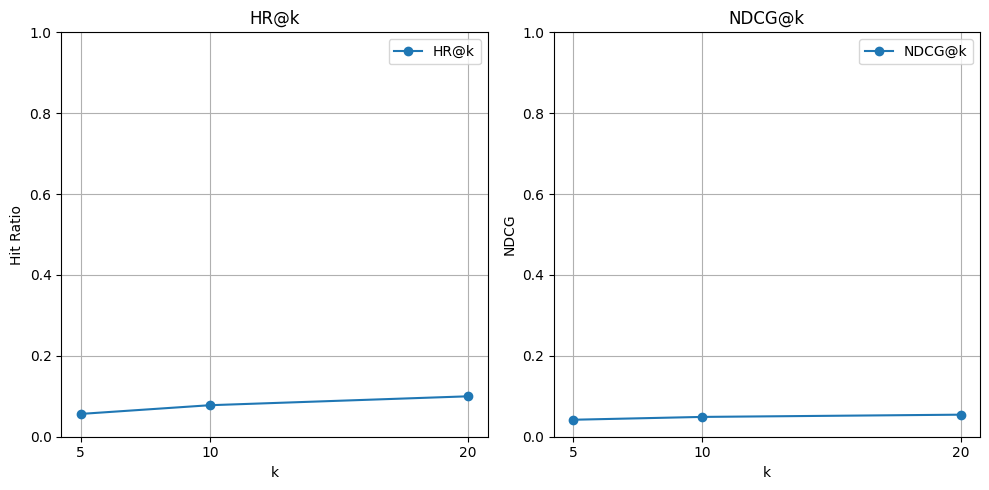

In [ ]:
import matplotlib.pyplot as plt

k_values = [5, 10, 20]
hr_values = [hr[k] for k in k_values]
ndcg_values = [ndcg[k] for k in k_values]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, hr_values, marker='o', label="HR@k")
plt.title("HR@k")
plt.xlabel("k")
plt.ylabel("Hit Ratio")
plt.xticks(k_values)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_values, ndcg_values, marker='o', label="NDCG@k")
plt.title("NDCG@k")
plt.xlabel("k")
plt.ylabel("NDCG")
plt.xticks(k_values)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
